In [23]:
!pip install pyale

In [1]:
!python --version

Python 3.11.6


In [19]:
!pip install ALEPython

ERROR: Could not find a version that satisfies the requirement ALEPython (from versions: none)
ERROR: No matching distribution found for ALEPython


In [38]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import os 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from interpret.blackbox import PartialDependence
from PyALE import ale
import matplotlib.ticker as ticker


In [12]:
data_path = os.path.dirname(os.getcwd())
data_df = pd.read_csv(os.path.join(data_path, "data/data_income.csv"))

# Define the features and target
X = data_df.drop(["income"], axis=1)
y = data_df["income"]

# Define the categorical columns to one-hot encode
categorical_cols = [
    "occupation",
    "education",
    "workclass",
    "marital-status",
    "relationship",
    "race",
    "native-country",
    "gender",
]
numeric_cols = [
    "age",
    "fnlwgt",
    "educational-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# fix the format for y
y_train_bin = y_train.replace({">50K": 1, "<=50K": 0})
y_test_bin = y_test.replace({">50K": 1, "<=50K": 0})


In [13]:
# Define preprocessing for categorical and numeric data
categorical_preprocessor = OneHotEncoder()
numeric_preprocessor = StandardScaler()

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_preprocessor, categorical_cols),
        ("num", numeric_preprocessor, numeric_cols),
    ],
    remainder="passthrough",  # You can use this to include any remaining columns
)

# Create a pipeline with preprocessing and the machine learning model
model = XGBClassifier(random_state=42)

pipeline = Pipeline([("preprocessor", preprocessor), ("model", model)])
# Fit the pipeline (including preprocessing) to the training data
pipeline.fit(X_train, y_train_bin)
# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test_bin, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8775


In [14]:
# Get the feature names for the one-hot encoded categorical variables
one_hot_feature_names = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_cols)

# Combine with numeric feature names
all_feature_names = list(one_hot_feature_names) + numeric_cols

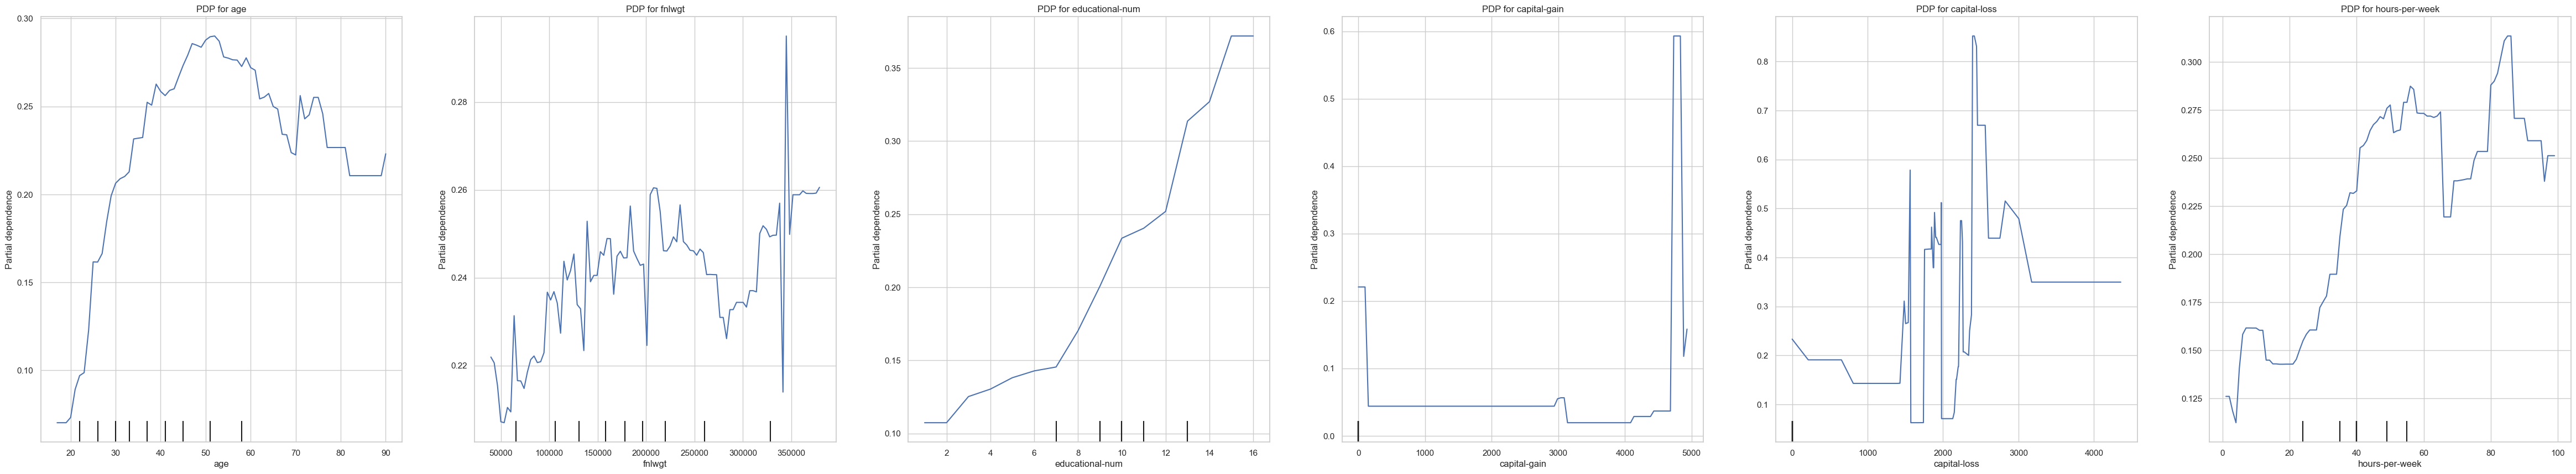

In [15]:
sns.set(style='whitegrid')

# Define the number of rows and columns for the subplots based on the number of features
n_features = len(numeric_cols)
n_cols = len(X_train.columns) # for example, adjust as needed
n_rows = (n_features + n_cols - 1) // n_cols

# Create a figure to hold the subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 10, n_rows * 10))
axs = axs.flatten()  # flatten the axis array for easy iteration

for i, feature in enumerate(numeric_cols):
    if i < n_features:
        ax = axs[i]  # Specify the subplot axis
        PartialDependenceDisplay.from_estimator(
            pipeline,
            X_train,
            features=[feature],
            feature_names=X_train.columns,
            kind="average",
            ax=ax  # Use the specified axis for the plot
        )
        ax.set_title(f'PDP for {feature}')  # Set the title for each subplot

for ax in axs[n_features:]:
    ax.set_visible(False)

# Show the plot
plt.show()


PyALE._ALE_generic:INFO: Discrete feature detected.


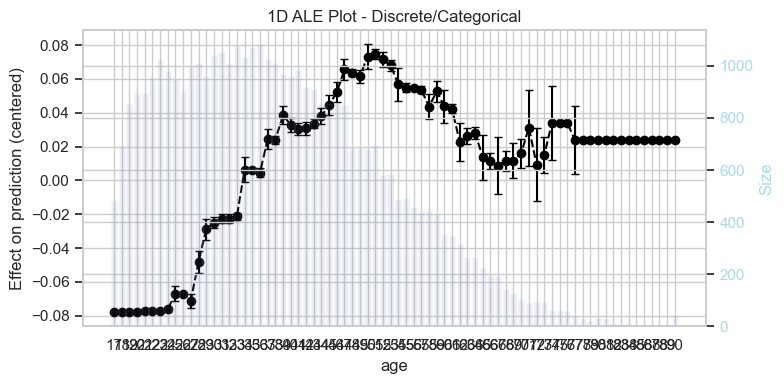

PyALE._ALE_generic:INFO: Continuous feature detected.


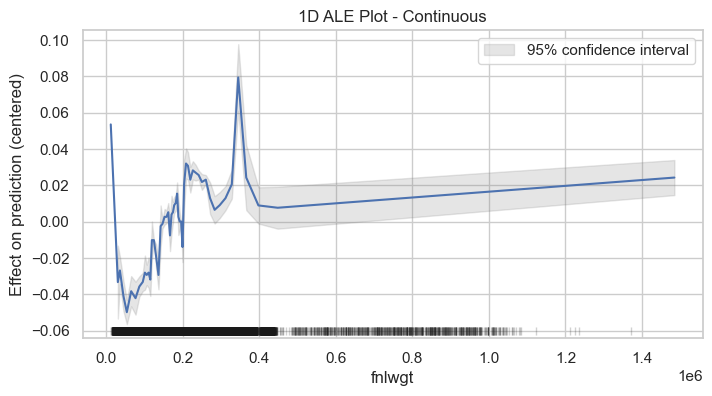

PyALE._ALE_generic:INFO: Discrete feature detected.


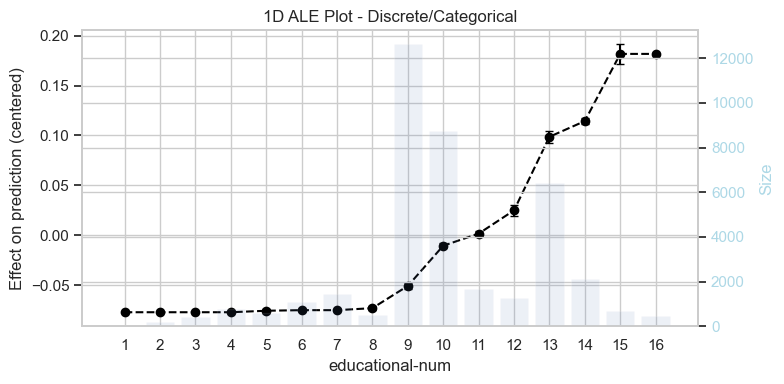

PyALE._ALE_generic:INFO: Continuous feature detected.


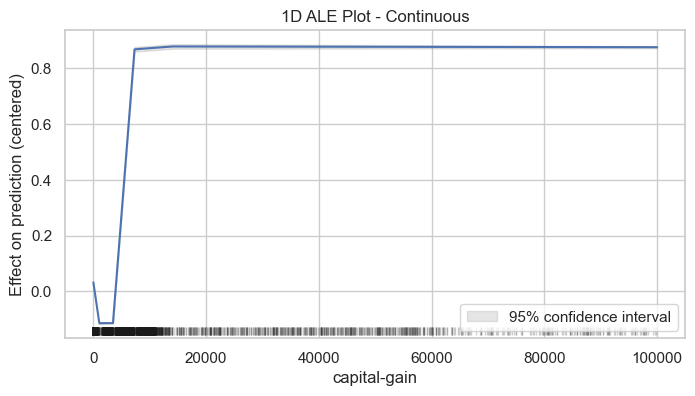

PyALE._ALE_generic:INFO: Continuous feature detected.


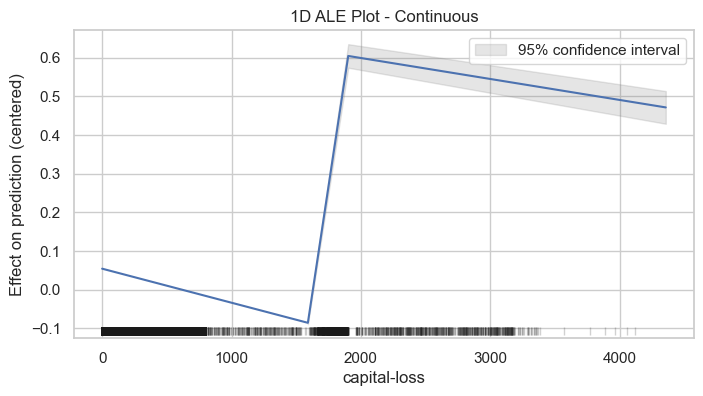

PyALE._ALE_generic:INFO: Continuous feature detected.


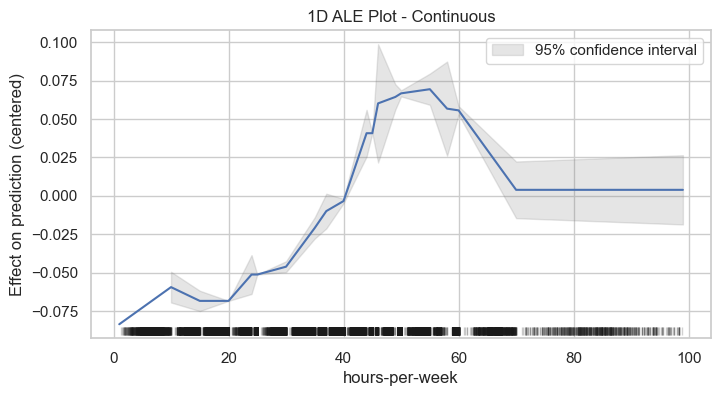

In [54]:
# Choose a feature for which to calculate ALE
for feature_name in numeric_cols: 

    # Calculate the ALE for the specified feature
    ale_effect = ale(X=X_train, model=pipeline, feature=[feature_name], grid_size=50)


    # You can then display the plot with matplotlib's show function
    plt.show()


In [71]:
X_train.head(6)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
37193,42,Private,145175,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
31093,52,Self-emp-not-inc,175029,10th,6,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,35,United-States
33814,34,Local-gov,172664,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
14500,28,Private,125791,HS-grad,9,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States
23399,46,Private,28419,Assoc-voc,11,Never-married,Transport-moving,Not-in-family,White,Male,0,0,50,United-States
27487,54,Federal-gov,439608,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States
